In [1]:
%matplotlib inline
import obspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates


from hydrophone_data_processing import load, preprocessing, tempmatch
# from multitaper.multitaper import Multitaper
# from spectrum import *
import spectrum

In [2]:
temp = tempmatch.make_template(hole='B')

In [3]:
detectfiles = '/media/sda/data/borehole/detections/*.csv'
bubbles = load.import_detections(detectfiles)

In [265]:
paths = ['/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.138'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.02.GDH.2019.138'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.03.GDH.2019.138'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.04.GDH.2019.138'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.05.GDH.2019.138'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.06.GDH.2019.138']

day138 = load.import_corrected_data_for_single_day(paths=paths)
day138.filter(type='highpass', corners=4, zerophase=True, freq=40)

6 Trace(s) in Stream:
7F.B00.01.GDH | 2019-05-18T00:00:02.907000Z - 2019-05-19T00:00:01.019000Z | 1000.0 Hz, 86398113 samples
7F.B00.02.GDH | 2019-05-18T00:00:01.540000Z - 2019-05-19T00:00:00.847000Z | 1000.0 Hz, 86399308 samples
7F.B00.03.GDH | 2019-05-18T00:00:02.689000Z - 2019-05-19T00:00:03.138000Z | 1000.0 Hz, 86400450 samples
7F.B00.04.GDH | 2019-05-18T00:00:02.341000Z - 2019-05-19T00:00:01.086000Z | 1000.0 Hz, 86398746 samples
7F.B00.05.GDH | 2019-05-18T00:00:02.971000Z - 2019-05-19T00:00:01.291000Z | 1000.0 Hz, 86398321 samples
7F.B00.06.GDH | 2019-05-18T00:00:02.192000Z - 2019-05-19T00:00:01.375000Z | 1000.0 Hz, 86399184 samples

In [266]:
day138

6 Trace(s) in Stream:
7F.B00.01.GDH | 2019-05-18T00:00:02.907000Z - 2019-05-19T00:00:01.019000Z | 1000.0 Hz, 86398113 samples
7F.B00.02.GDH | 2019-05-18T00:00:01.540000Z - 2019-05-19T00:00:00.847000Z | 1000.0 Hz, 86399308 samples
7F.B00.03.GDH | 2019-05-18T00:00:02.689000Z - 2019-05-19T00:00:03.138000Z | 1000.0 Hz, 86400450 samples
7F.B00.04.GDH | 2019-05-18T00:00:02.341000Z - 2019-05-19T00:00:01.086000Z | 1000.0 Hz, 86398746 samples
7F.B00.05.GDH | 2019-05-18T00:00:02.971000Z - 2019-05-19T00:00:01.291000Z | 1000.0 Hz, 86398321 samples
7F.B00.06.GDH | 2019-05-18T00:00:02.192000Z - 2019-05-19T00:00:01.375000Z | 1000.0 Hz, 86399184 samples

/home/john/anaconda3/envs/borehole/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


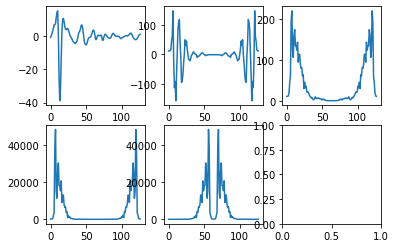

In [267]:
fig, ax = plt.subplots(2, 3)
ax[0][0].plot(temp[0].data)
y = np.fft.fft(temp[0].data)
ax[0][1].plot(y)
y = np.absolute(y)
ax[0][2].plot(y)
y = y**2
ax[1][0].plot(y)
y = np.fft.fftshift(y)
ax[1][1].plot(y)

In [268]:
128/4

32.0

In [269]:
def zero_pad(data, N, k):
    data_length = N*k
    extra_zeros = np.zeros(int(data_length - data.shape[0]))
    data = np.append(data, extra_zeros)
    return data

x = np.ones(10)
zero_pad(x, N=64, k=4).shape

(256,)

In [270]:
# N = 64
# # NW = 2.5
# NW = 3/2
# k = 4
# w, eigens = spectrum.dpss(N, NW, k)
# data = zero_pad(temp[0].data.copy(), N, k)
# data = np.reshape(data, (k, N))
# sk, weights, eigenvalues = spectrum.pmtm(data, e=eigens, v=w, method='eigen')
# sk[0].shape

In [271]:
def get_power_freq(N, NW, k, data):
    data = zero_pad(data, N, k)
    data = np.reshape(data, (k, N))
    w, eigens = spectrum.dpss(N, NW, k)
    sk, weights, eigenvalues = spectrum.pmtm(data, e=eigens, v=w, method='eigen')
    power = 10*np.log10(np.abs(np.mean(sk * sk.conj(), axis=0)))
    Tlength = 1000/(data.shape[0] * data.shape[1])
    freq = np.ones(power.shape) * Tlength
    freq = freq.cumsum()
    return freq, power

(0.0, 500.0)

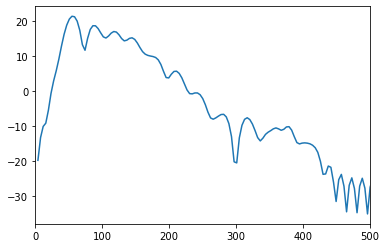

In [272]:
freq, power = get_power_freq(N=64, NW=3/2, k=4, data=temp[0].data.copy())

fig, ax = plt.subplots()
ax.plot(freq, power)
ax.set_xlim(0, 500)

(0.0, 500.0)

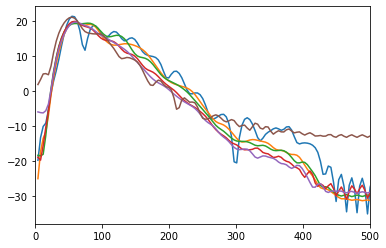

In [273]:
fig, ax = plt.subplots()
for tr in temp:
    freq, power = get_power_freq(N=64, NW=3/2, k=4, data=tr.data)
    ax.plot(freq, power)
    
ax.set_xlim(0, 500)

In [274]:
noise_data = day138.slice(starttime=temp[0].stats.endtime+5, endtime=temp[0].stats.endtime+5.2)

(0.0, 500.0)

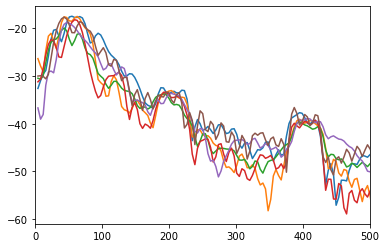

In [275]:
fig, ax = plt.subplots()
for tr in noise_data:
    freq, power = get_power_freq(N=64, NW=3/2, k=4, data=tr.data)
    ax.plot(freq, power)
ax.set_xlim(0, 500)

Text(0.5, 0, 'Frequency, Hz')

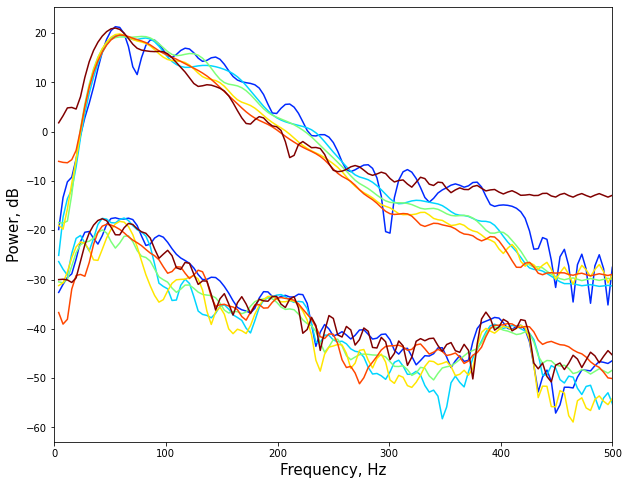

In [276]:
fig, ax = plt.subplots(figsize=(10, 8))

import matplotlib

cm = matplotlib.cm.jet

n = 0
for tr_bubble, tr_noise in zip(temp, noise_data):
    n+=1
    
    freq, power = get_power_freq(N=64, NW=3/2, k=4, data=tr_bubble.data)
    ax.plot(freq, power, color=cm(n/6))
    
    freq, power = get_power_freq(N=64, NW=3/2, k=4, data=tr_noise.data)
    ax.plot(freq, power, color=cm(n/6))
    
ax.set_xlim(0, 500)
ax.set_ylabel('Power, dB', fontsize=15)
ax.set_xlabel('Frequency, Hz', fontsize=15)

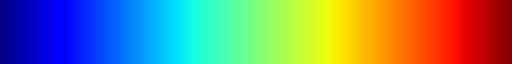

In [278]:
cm

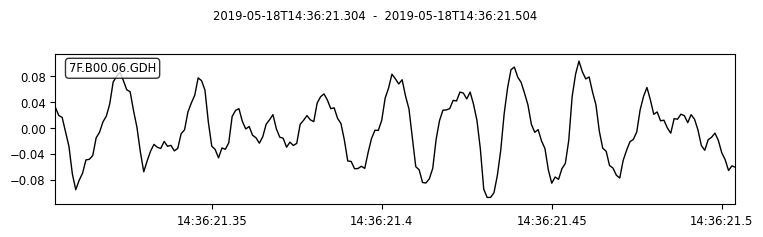

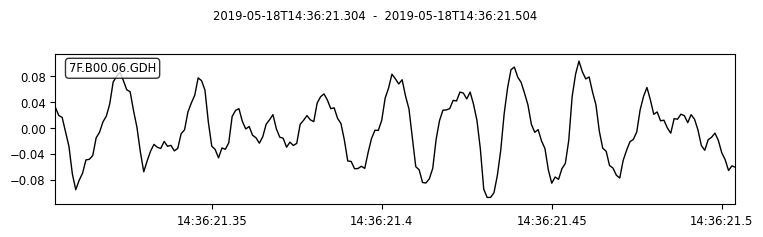

In [277]:
tr_noise.plot()

(127,)


Text(0.5, 0, 'Frequency, Hz')

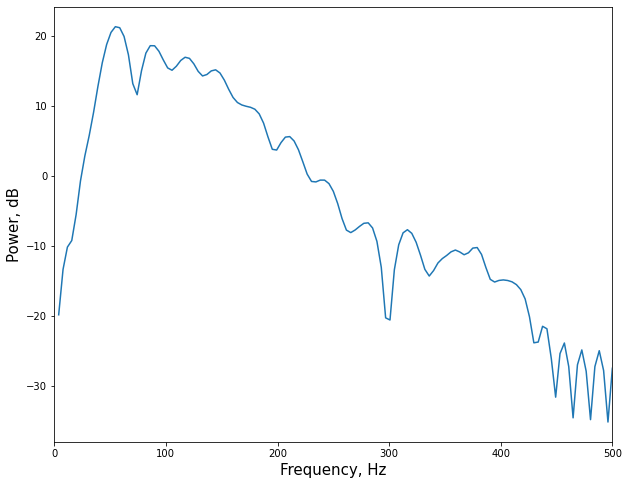

In [232]:
# set dpss window
N = 64 # desired window length
NW = 3/2 # half bandwidth parameter
k = 4 # number of Slepian sequences to return

# this is the original bubble template for 
data_to_analyse = temp[0].data.copy()
print(data_to_analyse.shape)

# zero pad the data to make it acceptable shape
# original length 127
data = zero_pad(data_to_analyse, N, k)
data = np.reshape(data, (k, N))

w, eigens = spectrum.dpss(N, NW, k)
sk, weights, eigenvalues = spectrum.pmtm(data, e=eigens, v=w, method='eigen')

# use first slepian sequence
# multiply by conjugate
# take absolute value (python keeps x+0j, x-0j and labels it as complex type)
# y = np.abs(sk[0] * sk[0].conj())
y = np.abs(np.mean(sk * sk.conj(), axis=0))

# calculate window length (this should be 3.90625s for 1000Hz of 256 length zero padded data)
Tlength = 1000/(data.shape[0] * data.shape[1])

# calculate maximum x, this should be 1000Hz
xmax = y.shape[0] * Tlength

# create x values, this should be increasing from 0 to 1000Hz at 3.90625Hz
x = np.ones(y.shape)*Tlength
x = x.cumsum()

y = 10*np.log10(y)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x, y)
ax.set_xlim(0, 500)
# ax.set_ylabel('$Pa^2 Hz^{-1}$', fontsize=15)
ax.set_ylabel('Power, dB', fontsize=15)
ax.set_xlabel('Frequency, Hz', fontsize=15)

In [231]:
# set dpss window
N = 64 # desired window length
NW = 3/2 # half bandwidth parameter
k = 4 # number of Slepian sequences to return

# this is the original bubble template for 
# data_to_analyse = temp[0].data.copy()
data_to_analyse = [tr.data.copy() for tr in temp]
# print(data_to_analyse.shape)

# zero pad the data to make it acceptable shape
# original length 127
# data = zero_pad(data_to_analyse, N, k)
data = [zero_pad(d, N, k) for d in data_to_analyse]
# data = np.reshape(data, (k, N))
data = [np.reshape(d, (k, N)) for d in data]

w, eigens = spectrum.dpss(N, NW, k)
sk, weights, eigenvalues = spectrum.pmtm(data, e=eigens, v=w, method='eigen')

# use first slepian sequence
# multiply by conjugate
# take absolute value (python keeps x+0j, x-0j and labels it as complex type)
# y = np.abs(sk[0] * sk[0].conj())
y = np.abs(np.mean(sk * sk.conj(), axis=0))

# calculate window length (this should be 3.90625s for 1000Hz of 256 length zero padded data)
Tlength = 1000/(data.shape[0] * data.shape[1])

# calculate maximum x, this should be 1000Hz
xmax = y.shape[0] * Tlength

# create x values, this should be increasing from 0 to 1000Hz at 3.90625Hz
x = np.ones(y.shape)*Tlength
x = x.cumsum()

y = 10*np.log10(y)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x, y)
ax.set_xlim(0, 500)
# ax.set_ylabel('$Pa^2 Hz^{-1}$', fontsize=15)
ax.set_ylabel('Power, dB', fontsize=15)
ax.set_xlabel('Frequency, Hz', fontsize=15)

array([  1.03358796e-02+0.j,   4.59377303e-02+0.j,   9.55752040e-02+0.j,
         1.18653085e-01+0.j,   2.78369072e-01+0.j,   8.41738434e-01+0.j,
         1.91070537e+00+0.j,   3.73313643e+00+0.j,   7.99158030e+00+0.j,
         1.87814182e+01+0.j,   4.08336868e+01+0.j,   7.44318723e+01+0.j,
         1.10791080e+02+0.j,   1.33725798e+02+0.j,   1.29268524e+02+0.j,
         9.69879886e+01+0.j,   5.30256207e+01+0.j,   2.05543702e+01+0.j,
         1.42983248e+01+0.j,   3.14847104e+01+0.j,   5.60851726e+01+0.j,
         7.16196663e+01+0.j,   7.14224970e+01+0.j,   5.95605968e+01+0.j,
         4.48065548e+01+0.j,   3.44909780e+01+0.j,   3.19528728e+01+0.j,
         3.65026807e+01+0.j,   4.40845349e+01+0.j,   4.89900834e+01+0.j,
         4.72074024e+01+0.j,   3.94581569e+01+0.j,   3.08003608e+01+0.j,
         2.65004900e+01+0.j,   2.77746545e+01+0.j,   3.12693747e+01+0.j,
         3.24118999e+01+0.j,   2.91902106e+01+0.j,   2.30928256e+01+0.j,
         1.70825972e+01+0.j,   1.30657503e+01+0.j, 

In [202]:
weights

array([[ 0.99889949],
       [ 0.48434221],
       [ 0.2442756 ],
       [ 0.06562403]])

In [210]:
x

array([    3.90625,     7.8125 ,    11.71875,    15.625  ,    19.53125,
          23.4375 ,    27.34375,    31.25   ,    35.15625,    39.0625 ,
          42.96875,    46.875  ,    50.78125,    54.6875 ,    58.59375,
          62.5    ,    66.40625,    70.3125 ,    74.21875,    78.125  ,
          82.03125,    85.9375 ,    89.84375,    93.75   ,    97.65625,
         101.5625 ,   105.46875,   109.375  ,   113.28125,   117.1875 ,
         121.09375,   125.     ,   128.90625,   132.8125 ,   136.71875,
         140.625  ,   144.53125,   148.4375 ,   152.34375,   156.25   ,
         160.15625,   164.0625 ,   167.96875,   171.875  ,   175.78125,
         179.6875 ,   183.59375,   187.5    ,   191.40625,   195.3125 ,
         199.21875,   203.125  ,   207.03125,   210.9375 ,   214.84375,
         218.75   ,   222.65625,   226.5625 ,   230.46875,   234.375  ,
         238.28125,   242.1875 ,   246.09375,   250.     ,   253.90625,
         257.8125 ,   261.71875,   265.625  ,   269.53125,   273

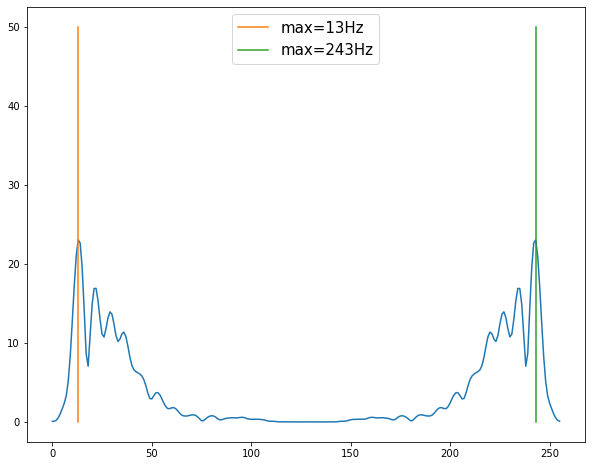

In [148]:
fig, ax = plt.subplots(figsize=(10, 8))
sk0 = np.abs(sk[0])
ax.plot(sk0)
ax.plot([np.argmax(sk0), np.argmax(sk0)]
         , [0, 50]
         , label='max={}Hz'.format(np.argmax(sk0))
         )
ax.plot([np.argmax(sk0[50:])+50, np.argmax(sk0[50:])+50]
         , [0, 50]
         , label='max={}Hz'.format(np.argmax(sk0[50:])+50)
         )
ax.legend(fontsize=15)

(0.0, 125.0)

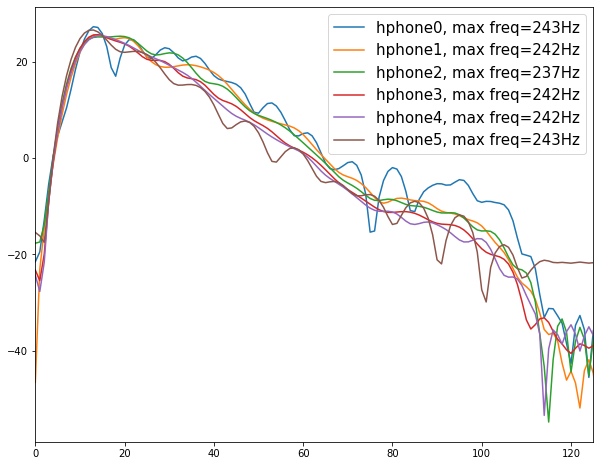

In [108]:
fig, ax = plt.subplots(figsize=(10, 8))

for n,t in enumerate(temp):
    N = 64
    # NW = 2.5
    NW = 3/2
    k = 4
    w, eigens = spectrum.dpss(N, NW, k)
    # data = zero_pad(temp[0].data.copy(), N, k)
    data = zero_pad(t.data.copy(), N, k)
    # data = np.reshape(data, (4, 32))
    data = np.reshape(data, (k, N))
    sk, weights, eigenvalues = spectrum.pmtm(data, e=eigens, v=w, method='eigen')
    
    # sk0 = np.abs(sk[0])
    sk0 = np.abs(sk[0]*weights[0])
    sk0 = 10*np.log10(sk0**2)
    # sk0 = 10*np.log10(sk0)
    ax.plot(sk0, label='hphone{n}, max freq={f}Hz'.format(n=n, f=np.argmax(sk0[50:])+50))
    # ax.plot([np.argmax(sk0), np.argmax(sk0)]
    #          , [0, 50]
    #          , label='max={}Hz'.format(np.argmax(sk0))
    #          )
    # ax.plot([np.argmax(sk0[50:])+50, np.argmax(sk0[50:])+50]
    #          , [0, 50]
    #          , label='max={}Hz'.format(np.argmax(sk0[50:])+50)
    #          )
ax.legend(fontsize=15)
ax.set_xlim(0, 125)
# ax.set_ylim(-5, 30)
# ax.set_yscale('log')

In [104]:
weights[0]

array([ 0.99889949])

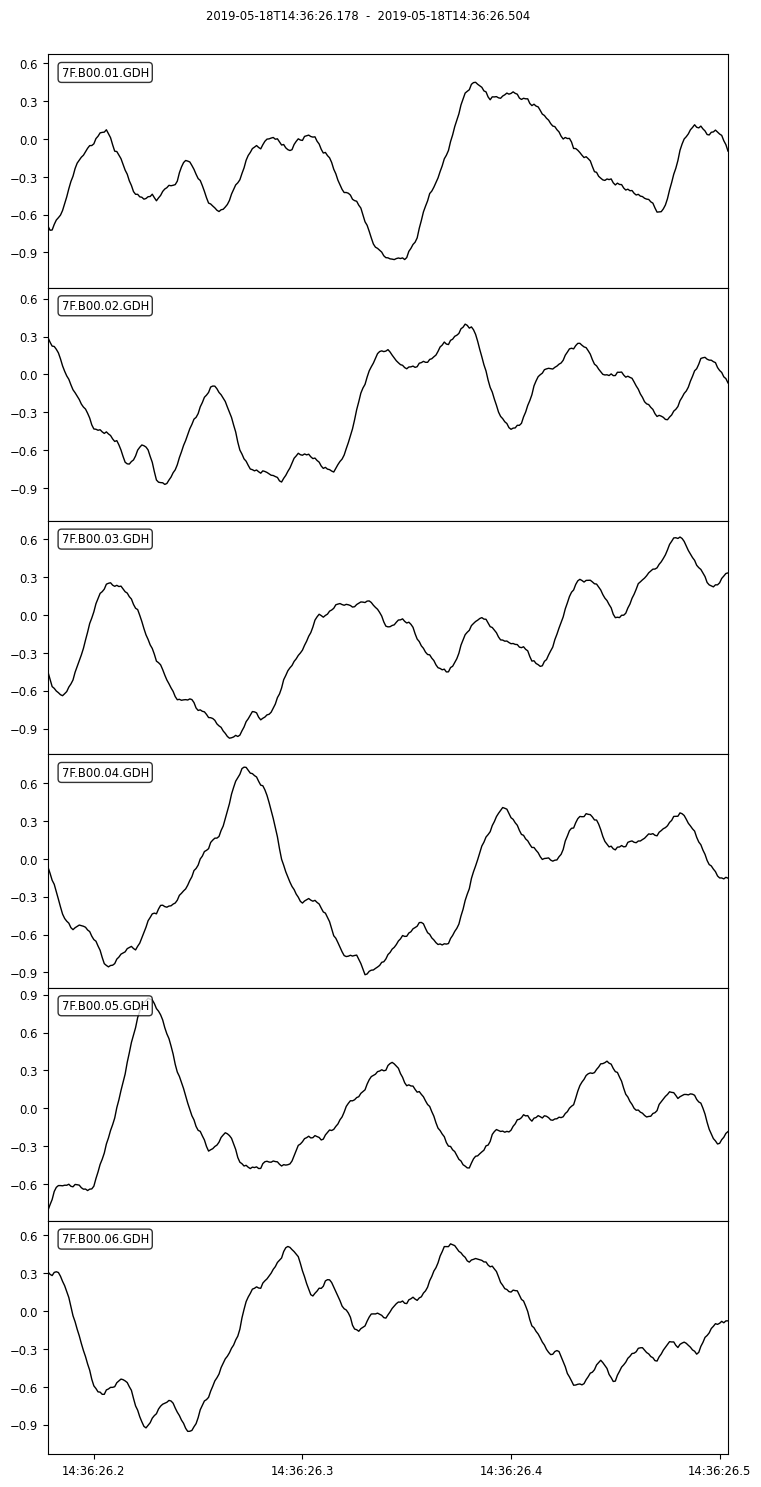

(200.0, 260.0)

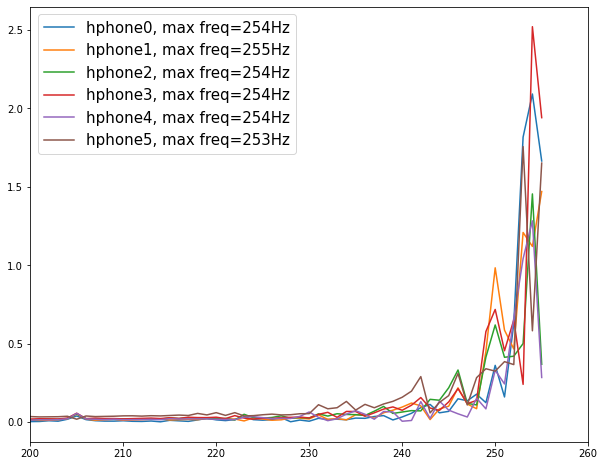

In [93]:
data = day138.slice(starttime=temp[0].stats.starttime+10, endtime=temp[0].stats.endtime+10.2).copy()
x = data.plot()
fig, ax = plt.subplots(figsize=(10, 8))

for n,t in enumerate(data):
    N = 512
    # NW = 2.5
    NW = 3/2
    k = 4
    w, eigens = spectrum.dpss(N, NW, k)
    # data = zero_pad(temp[0].data.copy(), N, k)
    data = zero_pad(t.data.copy(), N, k)
    # data = np.reshape(data, (4, 32))
    data = np.reshape(data, (k, N))
    sk, weights, eigenvalues = spectrum.pmtm(data, e=eigens, v=w, method='eigen')
    
    sk0 = np.abs(sk[0])
    ax.plot(sk0, label='hphone{n}, max freq={f}Hz'.format(n=n, f=np.argmax(sk0[50:])+50))
    # ax.plot([np.argmax(sk0), np.argmax(sk0)]
    #          , [0, 50]
    #          , label='max={}Hz'.format(np.argmax(sk0))
    #          )
    # ax.plot([np.argmax(sk0[50:])+50, np.argmax(sk0[50:])+50]
    #          , [0, 50]
    #          , label='max={}Hz'.format(np.argmax(sk0[50:])+50)
    #          )
ax.legend(fontsize=15)
ax.set_xlim(200, 260)
# ax.set_ylim(-5, 30)

In [2]:
import numpy as np
def minnaert_radius(freq):
    # gamma = np.mean([1.3, 1.67]) # dimensionless
    # https://www.engineeringtoolbox.com/specific-heat-capacity-gases-d_159.html
    gamma = 1.405 # taken from website above for 300K
    # PA = 2.5 # bar, 100 kPa, N/m^2, kg*m/s^2m^2 = 100000 kg*m/(s^2 m^2) = 100000 kg/(m*s^2)
    # rho = 1 # density of water, 997 kg/m^3
    PA = 2.5 * 100000 # kg/(m*s^2)
    rho = 997 # kg/m^3
    # PA/rho => PA(kg*m^-1*s^-2) / rho(kg * m^-3) =? PA(...) * rho(kg^-1 * m^3) => m^2 * s^-2
    return (2 * np.pi * freq)**(-1) * ((3 * gamma * PA)/(rho))**(1/2)

In [14]:
minnaert_radius(freq=21) # units - meters

0.24638941792829613

In [15]:
minnaert_radius(freq=235) # units - meters

0.022017777772315825

In [16]:
np.mean([1.3, 1.67])

1.4849999999999999

In [17]:
np.savetxt(X=temp[0].data, delimiter=',', fname='bubbletemplate.csv')

In [18]:
# data.shape

In [19]:
# data_length


In [20]:
# for n in np.arange(0, 10, 2):
#     print(n*n)

In [21]:
# mtp = Multitaper(16)

In [22]:
# data = temp[0].data.copy()
# data = np.append(data, (0,))
# np.reshape(data, (6, 16))

In [23]:
# plt.plot(mtp.estimate(np.reshape(data, (-1, 16))))

In [24]:
# 126/6

In [25]:
# mtp.estimate(data)

In [26]:
# np.reshape(temp[0].data, (3, 3))

In [27]:
# 127/7

In [28]:
# np.reshape(temp[0].data, (7, -1))

In [29]:
# mymtm = Multitaper(2048)
# sig = np.vectorize(complex)(np.random.rand(2048), np.random.rand(2048))
# plt.plot(mymtm.estimate(sig))
# plt.yscale('log')

In [30]:
# sig

In [31]:
# mymtm = Multitaper(256)
# sig = np.reshape(sig, (8, 256))
# print(mymtm.estimate(sig))